In [1]:
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt
import os
import urllib.request
import json

%matplotlib inline
plt.style.use('seaborn-darkgrid')
tf.compat.v1.disable_eager_execution()

### Downloading or Loading Data From Kaggle or Alphavantage API

In [5]:
data_source = 'alphavantage'

ticker = 'HPQ'

if data_source == 'alphavantage':
    
    api_key = '77O6WJAAZ5C6UUUZ'    
    
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={0}&outputsize=full&apikey={1}'.format(ticker,api_key)
    
    save = 'stock-market-data-{0}'.format(ticker)
    
    if not os.path.exists(save):
        
        with urllib.request.urlopen(url) as url:
            
            data = json.loads(url.read().decode())
            
            data = data['Time Series (Daily)']
            
            df = pd.DataFrame(columns=[
                'Date',
                'Low',
                'High',
                'Close',
                'Open'
            ])
            
            for key, value in data.items():
                
                date = dt.datetime.strptime(key, '%Y-%m-%d')
                
                row = [date.date(),
                       float(value['3. low']),
                       float(value['2. high']),
                       float(value['4. close']),
                       float(value['1. open'])]
                
                df.loc[-1, :] = row
                
                df.index = df.index + 1
            
        print('Data Saved To : ', save)
        
        df.to_csv(save)
    
    else:
        
        print('File Already Created. Loading Current CSV File...')
        
        df = pd.read_csv(save)
        
else:
    
    df = pd.read_csv(os.path.join('archive', 'Stocks', ticker.lower()+'.us.txt'),
                     delimiter=',', usecols=['Date', 'Low', 'High', 'Close', 'Open'])
    
    print('Data Loaded From Kaggle...')

File Already Created. Loading Current CSV File...


In [6]:
df

,Unnamed: 0,Date,Low,High,Close,Open
0,5308,2020-12-04,23.250,23.880,23.78,23.260
1,5307,2020-12-03,22.760,23.430,23.24,22.800
2,5306,2020-12-02,22.255,22.980,22.82,22.355
3,5305,2020-12-01,22.080,22.590,22.38,22.220
4,5304,2020-11-30,21.800,22.285,21.93,22.090
...,...,...,...,...,...,...
5304,4,1999-11-05,77.440,79.880,77.63,78.690
5305,3,1999-11-04,73.810,76.940,76.69,74.310
5306,2,1999-11-03,71.810,73.940,73.38,73.940
5307,1,1999-11-02,72.190,75.060,72.25,75.000


In [7]:
df = df.sort_values('Date')

df.tail()

,Unnamed: 0,Date,Low,High,Close,Open
4,5304,2020-11-30,21.800,22.285,21.93,22.090
3,5305,2020-12-01,22.080,22.590,22.38,22.220
2,5306,2020-12-02,22.255,22.980,22.82,22.355
1,5307,2020-12-03,22.760,23.430,23.24,22.800
0,5308,2020-12-04,23.250,23.880,23.78,23.260


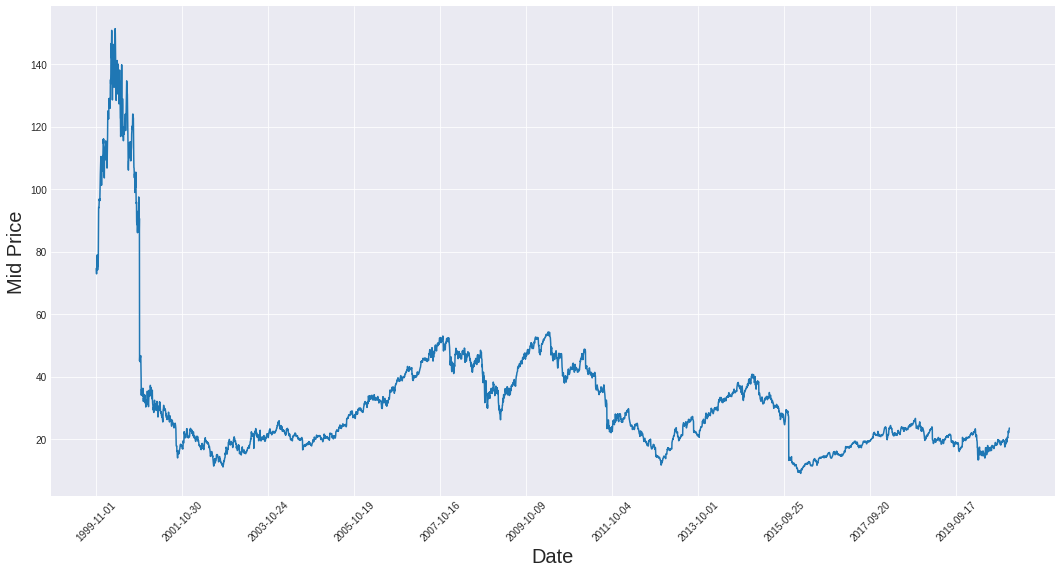

In [8]:
plt.figure(figsize=(18, 9))

plt.plot(range(df.shape[0]), (df['Low'] + df['High']) / 2.0)

plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[ : : 500], rotation=45)

plt.xlabel('Date', fontsize=20)

plt.ylabel('Mid Price', fontsize=20)

plt.show()

### Data Splitting

In [9]:
high = df.loc[:, 'High'].to_numpy()

low = df.loc[:, 'Low'].to_numpy()

mid = (high + low) / 2.0

In [11]:
percentage = 0.80

split_point = int(len(mid) * percentage)
# split_point = 11000

train_data = mid[ : split_point]

test_data = mid[split_point : ]

### Data Normalization

In [12]:
scaler = MinMaxScaler()

train_data = train_data.reshape(-1, 1)

test_data = test_data.reshape(-1, 1)

In [13]:
smoothing_window_size = 0

if split_point > 10000:
    
    smoothing_window_size = 2000

elif split_point > 5000:
    
    smoothing_window_size = 1000
    
elif split_point > 2500:
    
    smoothing_window_size = 500
    
else:
    
    smoothing_window_size = 250

out_range = int(split_point / smoothing_window_size) * smoothing_window_size

for di in range(0, out_range, smoothing_window_size):
    
    scaler.fit(train_data[di: di + smoothing_window_size, :])
    
    train_data[di: di + smoothing_window_size, :] = scaler.transform(train_data[di: di + smoothing_window_size, :])
    
    
    
# Normalize Last bit of Data
scaler.fit(train_data[di + smoothing_window_size:, :])

train_data[di + smoothing_window_size: , :] = scaler.transform(train_data[di + smoothing_window_size:, :])

In [14]:
# Reshaping to Original Size of Data

train_data = train_data.reshape(-1)

test_data = scaler.transform(test_data).reshape(-1)

We can now smooth the data using the exponential moving average. This helps you to get rid of the inherent raggedness of the data in stock prices and produce a smoother curve.

In [18]:
EMA = 0.0

gamma = 0.1

for ti in range(split_point):
    
    EMA = gamma * train_data[ti] + (1 - gamma) * EMA
    
    train_data[ti] = EMA
    
all_mid_data = np.concatenate([train_data, test_data], axis=0)

### One Step Ahead Prediction using Averaging

We havetwo types of moving averages here:
1. Standard Average
2. Exponential Moving Average (EMA)

In [19]:
# Standard Average

window_size = 100

N = train_data.size

std_avg_predictions = []

std_avg_x = []

mse_errors = []

for pred_idx in range(window_size, N):
    
    if pred_idx >= N:
        
        date = dt.datetime.strptime(key, '%Y-%m-%d')
        
    else:
        
        date = df.loc[pred_idx, 'Date']
        
    std_avg_predictions.append(np.mean(train_data[pred_idx - window_size: pred_idx]))
    
    mse_errors.append((std_avg_predictions[-1] - train_data[pred_idx]) ** 2)
    
    std_avg_x.append(date)
    
print('MSE error for standard avaeraging: %.5f' % (0.5 * np.mean(mse_errors)) )

MSE error for standard avaeraging: 0.01394


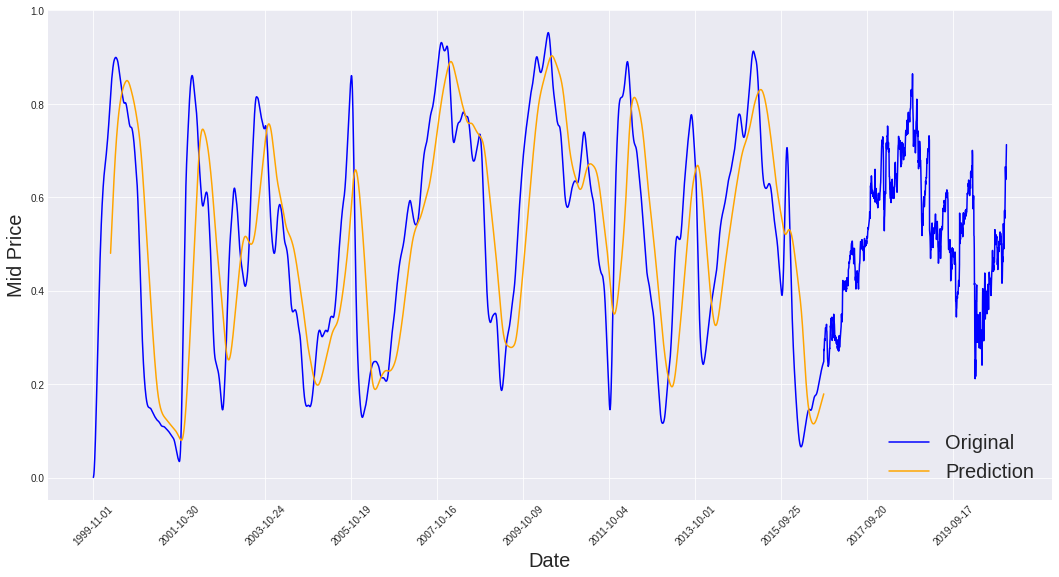

In [20]:
plt.figure(figsize=(18, 9))

plt.plot(range(df.shape[0]), all_mid_data, color='b', label='Original')

plt.plot(range(window_size, N), std_avg_predictions, color='orange', label='Prediction')

plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[ : : 500], rotation=45)

plt.xlabel('Date', fontsize=20)

plt.ylabel('Mid Price', fontsize=20)

plt.legend(fontsize=20)

plt.show()

In [21]:
# Exponential Moving Average

window_size = 100

N = train_data.size

run_avg_predictions = []

run_avg_x = []

mse_errors = []

running_mean = 0.0

run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1, N):
    
    running_mean = running_mean * decay + (1.0 - decay) * train_data[pred_idx - 1]
        
    run_avg_predictions.append(running_mean)
    
    mse_errors.append((run_avg_predictions[-1] - train_data[pred_idx]) ** 2)
    
    run_avg_x.append(date)
    
print('MSE error for EMA averaging: %.5f' % (0.5 * np.mean(mse_errors)) )

MSE error for EMA averaging: 0.00005


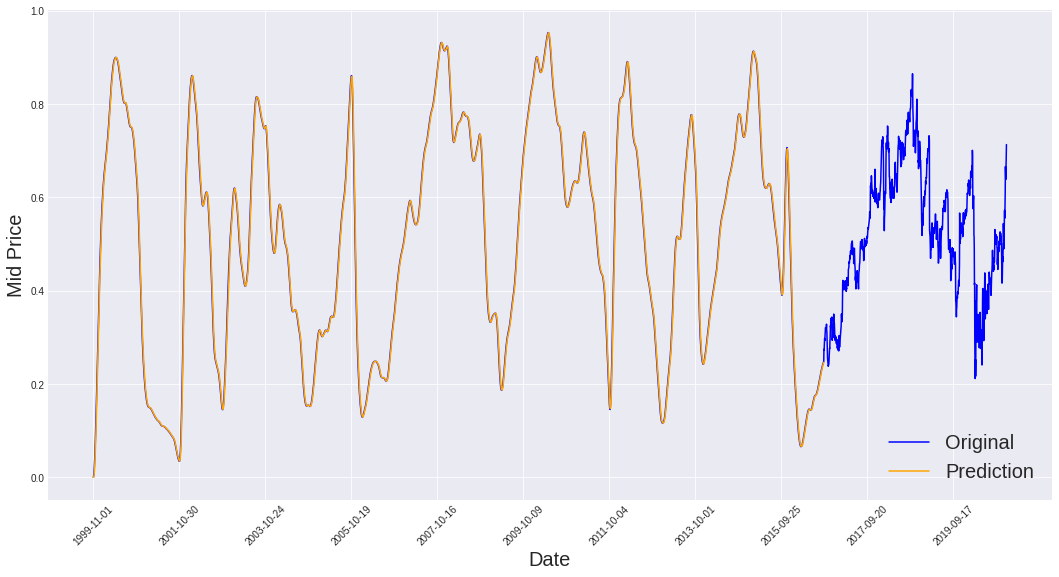

In [22]:
plt.figure(figsize=(18, 9))

plt.plot(range(df.shape[0]), all_mid_data, color='b', label='Original')

plt.plot(range(0, N), run_avg_predictions, color='orange', label='Prediction')

plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[ : : 500], rotation=45)

plt.xlabel('Date', fontsize=20)

plt.ylabel('Mid Price', fontsize=20)

plt.legend(fontsize=20)

plt.show()

In [24]:
class DataGeneratorSeq(object):
    
    def __init__(self, prices, batch_size, num_unroll):
        
        self._prices = prices
        
        self._prices_length = len(self._prices) - num_unroll
        
        self._batch_size = batch_size
        
        self._num_unroll = num_unroll
        
        self._segments = self._prices_length // self._batch_size
        
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]
        
        
    def next_batch(self):

        batch_data = np.zeros((self._batch_size), dtype=np.float32)
        
        batch_labels = np.zeros((self._batch_size), dtype=np.float32)

        for b in range(self._batch_size):
        
            if self._cursor[b] + 1 >= self._prices_length:
                
#                 self._cursor[b] = b * self._segments
                
                self._cursor[b] = np.random.randint(0, (b + 1) * self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            
            batch_labels[b]= self._prices[self._cursor[b] + np.random.randint(0, 5)]

            self._cursor[b] = (self._cursor[b] + 1) % self._prices_length
        
        return batch_data, batch_labels

    
    def unroll_batches(self):

        unroll_data,unroll_labels = [], []
        
        init_data, init_label = None, None
        
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    
    def reset_indices(self):
        
        for b in range(self._batch_size):
            
            self._cursor[b] = np.random.randint(0, min((b + 1) * self._segments, self._prices_length - 1))



dg = DataGeneratorSeq(train_data, 5, 5)

u_data, u_labels = dg.unroll_batches()

for ui, (dat, lbl) in enumerate(zip(u_data, u_labels)):   
    
    print('\n\nUnrolled index %d' % ui)
    
    dat_ind = dat
    
    lbl_ind = lbl
    
    print('\tInputs: ', dat)
    
    print('\n\tOutput:', lbl)



Unrolled index 0
	Inputs:  [4.4133284e-04 5.0662136e-01 2.0875961e-01 8.2397616e-01 5.1564187e-01]

	Output: [0.00162587 0.5009692  0.20711213 0.83153117 0.51564187]


Unrolled index 1
	Inputs:  [0.00162587 0.5009692  0.20814212 0.8258997  0.5161431 ]

	Output: [0.01678928 0.48621958 0.20674177 0.8296558  0.51630896]


Unrolled index 2
	Inputs:  [0.00374621 0.4957046  0.2075842  0.82778114 0.51630896]

	Output: [0.02346878 0.47801954 0.20650372 0.8334255  0.51473933]


Unrolled index 3
	Inputs:  [0.00693265 0.49079236 0.20711213 0.8296558  0.5161942 ]

	Output: [0.01127106 0.4743279  0.20711213 0.8296558  0.5158634 ]


Unrolled index 4
	Inputs:  [0.01127106 0.48621958 0.20674177 0.83153117 0.5158634 ]

	Output: [0.03123185 0.4743279  0.20650372 0.8334255  0.5158634 ]


### Defining Hyper Parameters

In [25]:
D = 1 # Dimension of Input Data

num_unrollings = 50 # Number of Days we look into Future

batch_size = 500 # Samples per Batch

num_nodes = [200, 200, 150] # Hidden layer nodes we will use in LSTM stack

n_layers = len(num_nodes) # Total number of layers

dropout = 0.2

tf.compat.v1.reset_default_graph()

In [27]:
train_inputs, train_outputs = [], []

for ui in range(num_unrollings):
    
    train_inputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size, D], name='train_inputs_{0}'.format(ui)))
    
    train_outputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size, 1], name='train_outputs_{0}'.format(ui)))

### Parameters of LSTM and Regression Layer

In [28]:
lstm_cells = [
    tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=num_nodes[li],
                           state_is_tuple=True,
                           initializer=tf.initializers.GlorotUniform()
                                     ) for li in range(n_layers)]

drop_lstm_cells = [tf.compat.v1.nn.rnn_cell.DropoutWrapper(
    lstm, input_keep_prob=1.0, output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]

drop_multi_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(drop_lstm_cells)

multi_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(lstm_cells)

with tf.compat.v1.variable_scope('w', reuse=tf.compat.v1.AUTO_REUSE) as scope:
    
    w = tf.compat.v1.get_variable('w', shape=[num_nodes[-1], 1], initializer=tf.initializers.GlorotUniform())

with tf.compat.v1.variable_scope('b', reuse=tf.compat.v1.AUTO_REUSE) as scope:
    
    b = tf.compat.v1.get_variable('b', initializer=tf.random.uniform([1], -0.1, 0.1))

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Calculating LSTM output and Feeding it to the regression layer to get final prediction

In [31]:
c, h = [], []

initial_state = []

for li in range(n_layers):
    
    c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    
    h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    
    initial_state.append(tf.compat.v1.nn.rnn_cell.LSTMStateTuple(c[li], h[li]))
    
    
all_inputs = tf.concat([tf.expand_dims(t, 0) for t in train_inputs], axis=0)

all_lstm_outputs, state = tf.compat.v1.nn.dynamic_rnn(drop_multi_cell, 
                                              all_inputs, 
                                              initial_state=tuple(initial_state),
                                              time_major=True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size * num_unrollings, num_nodes[-1]])

all_outputs = tf.compat.v1.nn.xw_plus_b(all_lstm_outputs, w, b)

split_outputs = tf.split(all_outputs, num_unrollings, axis=0)

### Loss Calculation and Optimizer

In [32]:
print('Defining Training Loss')

loss = 0.0

with tf.control_dependencies([tf.compat.v1.assign(c[li], state[li][0]) for li in range(n_layers)] +
                             [tf.compat.v1.assign(h[li], state[li][1]) for li in range(n_layers)]):
    
    for ui in range(num_unrollings):
        
        loss += tf.reduce_mean(0.5 * (split_outputs[ui] - train_outputs[ui]) ** 2)
        
print('Learning Rate Decay Operations')

global_step = tf.Variable(0, trainable=False)

inc_gstep = tf.compat.v1.assign(global_step, global_step + 1)

tf_learning_rate = tf.compat.v1.placeholder(shape=None, dtype=tf.float32)

tf_min_learning_rate = tf.compat.v1.placeholder(shape=None, dtype=tf.float32)

learning_rate = tf.maximum(
    tf.compat.v1.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

print('TF Optimization Operations')

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)

gradients, v = zip(*optimizer.compute_gradients(loss))

gradient, _ = tf.clip_by_global_norm(gradients, 5.0)

optimizer = optimizer.apply_gradients(zip(gradients, v))

print('\tAll Done...')

Defining Training Loss
Learning Rate Decay Operations
TF Optimization Operations
	All Done...


In [34]:
print('Defining Prediction Related TF Functions')

sample_inputs = tf.compat.v1.placeholder(tf.float32, shape=[1, D])

sample_c, sample_h, initial_sample_state = [], [], []

for li in range(n_layers):
    
    sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    
    sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    
    initial_sample_state.append(tf.compat.v1.nn.rnn_cell.LSTMStateTuple(sample_c[li], sample_h[li]))
    

reset_sample_states = tf.group(*[tf.compat.v1.assign(sample_c[li], tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.compat.v1.assign(sample_h[li], tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.compat.v1.nn.dynamic_rnn(multi_cell, 
                                                           tf.expand_dims(sample_inputs, 0),
                                                           initial_state=tuple(initial_sample_state),
                                                           time_major=True,
                                                           dtype=tf.float32)

with tf.control_dependencies([tf.compat.v1.assign(sample_c[li], sample_state[li][0]) for li in range(n_layers)] +
                             [tf.compat.v1.assign(sample_h[li], sample_state[li][1]) for li in range(n_layers)]):
    sample_prediction = tf.compat.v1.nn.xw_plus_b(tf.reshape(sample_outputs, [1, -1]), w, b)
    
print('\tAll Done...')

Defining Prediction Related TF Functions
	All Done...


### Running The LSTM


In [35]:
Inputsepochs = 30

valid_sammary = 1

n_predict_once = 50

train_seq_length = train_data.size

train_mse_ot = []

test_mse_ot = []

prediction_over_time = []

session = tf.compat.v1.InteractiveSession()

tf.compat.v1.global_variables_initializer().run()

loss_nondecrease_count = 0

loss_nondecerase_threshold = 2

print('Initialized')

average_loss = 0

data_gen = DataGeneratorSeq(train_data, batch_size, num_unrollings)

x_axis_seq = []

test_points_seq = np.arange(split_point, int(len(mid) / 500) * 500, 50).tolist()

for ep in range(epochs):
    
    for step in range(train_seq_length // batch_size):
        
        u_data, u_labels = data_gen.unroll_batches()
        
        feed_dict = {}
        
        for ui, (dat, lbl) in enumerate(zip(u_data, u_labels)):
            
            feed_dict[train_inputs[ui]] = dat.reshape(-1, 1)
            
            feed_dict[train_outputs[ui]] = lbl.reshape(-1, 1)
            
        
        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate: 0.000001})
        
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        
        average_loss += l
        
    
    if (ep + 1) % valid_sammary == 0:
        
        average_loss = average_loss / (valid_sammary * (train_seq_length // batch_size))
        
        if (ep + 1) % valid_sammary == 0:
            
            print('Average Loss at step %d: %f' % (ep + 1, average_loss))
        
        train_mse_ot.append(average_loss)

        average_loss = 0

        prediction_seq = []

        mse_test_loss_seq = []

        for w_i in test_points_seq:

            mse_test_loss = 0.0

            our_predictions = []

            if (ep + 1) - valid_sammary == 0:

                x_axis = []

            for tr_i in range(w_i - num_unrollings +1 , w_i -1):

                current_price = all_mid_data[tr_i]

                feed_dict[sample_inputs] = np.array(current_price).reshape(1, 1)

                _ = session.run(sample_prediction, feed_dict = feed_dict)


            feed_dict = {}

            current_price = all_mid_data[w_i - 1]

            feed_dict[sample_inputs] = np.array(current_price).reshape(1, 1)

            for pred_i in range(n_predict_once):

                pred = session.run(sample_prediction, feed_dict=feed_dict)

                our_predictions.append(np.asscalar(pred))

                feed_dict[sample_inputs] = np.asarray(pred).reshape(-1, 1)

                if (ep + 1) - valid_sammary == 0:

                    x_axis.append(w_i + pred_i)

                mse_test_loss += 0.5 * (pred - all_mid_data[w_i + pred_i]) ** 2

            session.run(reset_sample_states)

            prediction_seq.append(np.array(our_predictions))

            mse_test_loss /= n_predict_once

            mse_test_loss_seq.append(mse_test_loss)

            if (ep + 1) - valid_sammary == 0:

                x_axis_seq.append(x_axis)

        current_test_mse = np.mean(mse_test_loss_seq)

        if len(test_mse_ot) > 0 and current_test_mse > min(test_mse_ot):

            loss_nondecrease_count += 1

        else:

            loss_nondecrease_count = 0

        if loss_nondecrease_count > loss_nondecerase_threshold:

            session.run(inc_gstep)

            loss_nondecrease_count = 0

        test_mse_ot.append(current_test_mse)

        print('\tTest MSE: %.5f' % np.mean(mse_test_loss_seq))

        prediction_over_time.append(prediction_seq)


Initialized
Average Loss at step 1: 7.754648


<ipython-input-35-51729f38e377>:100: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  our_predictions.append(np.asscalar(pred))


	Test MSE: 0.13943
Average Loss at step 2: 1.775614
	Test MSE: 0.03583
Average Loss at step 3: 0.842595
	Test MSE: 0.00425
Average Loss at step 4: 0.330403
	Test MSE: 0.02420
Average Loss at step 5: 0.336478
	Test MSE: 0.00231
Average Loss at step 6: 0.243440
	Test MSE: 0.00636
Average Loss at step 7: 0.208988
	Test MSE: 0.00442
Average Loss at step 8: 0.210353
	Test MSE: 0.00284
Average Loss at step 9: 0.194708
	Test MSE: 0.00227
Average Loss at step 10: 0.202715
	Test MSE: 0.00225
Average Loss at step 11: 0.190621
	Test MSE: 0.00245
Average Loss at step 12: 0.184667
	Test MSE: 0.00241
Average Loss at step 13: 0.174764
	Test MSE: 0.00226
Average Loss at step 14: 0.172043
	Test MSE: 0.00227
Average Loss at step 15: 0.171687
	Test MSE: 0.00229
Average Loss at step 16: 0.178139
	Test MSE: 0.00229
Average Loss at step 17: 0.176446
	Test MSE: 0.00229
Average Loss at step 18: 0.183462
	Test MSE: 0.00231
Average Loss at step 19: 0.178058
	Test MSE: 0.00233
Average Loss at step 20: 0.181277
	

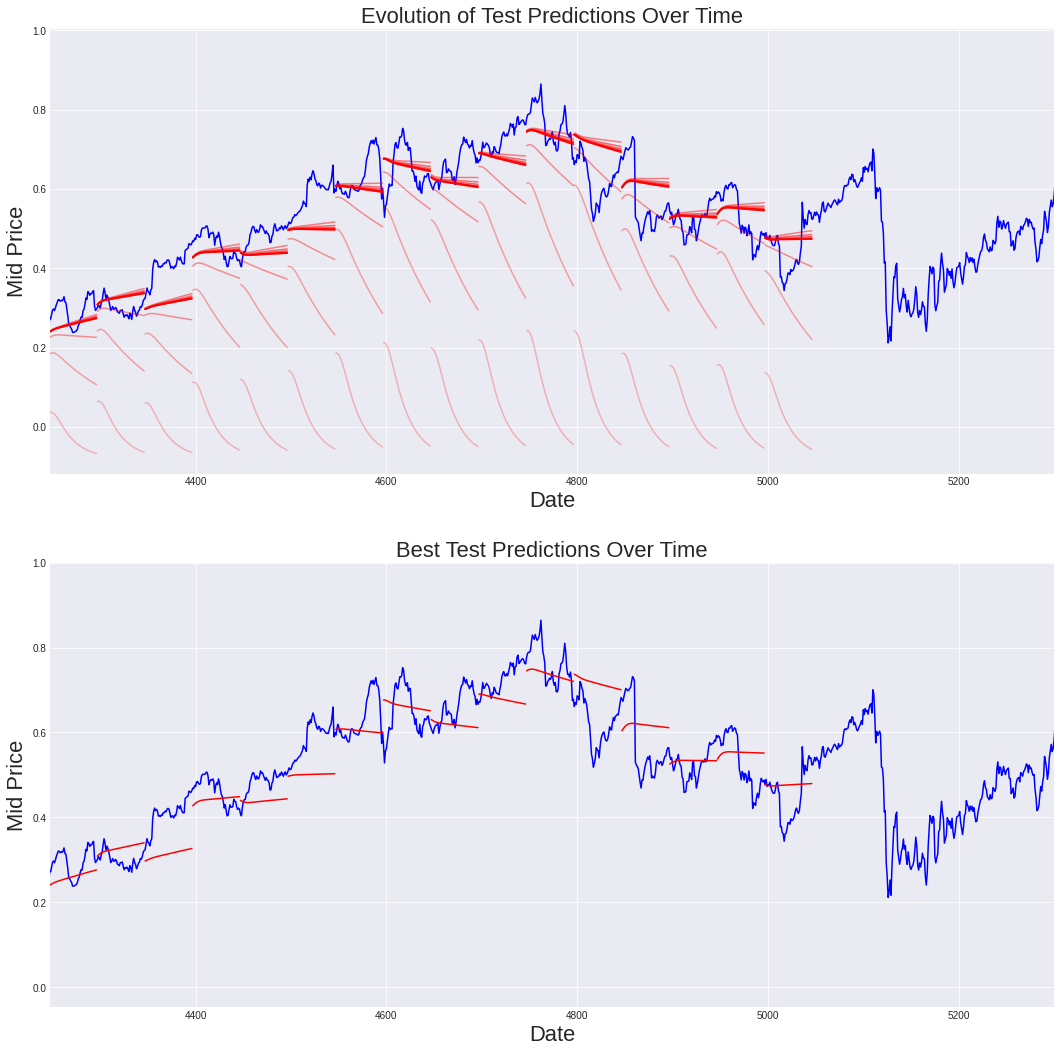

In [36]:
best_prediction_epoch = 15

plt.figure(figsize = (18, 18))

plt.subplot(2, 1, 1)

plt.plot(range(df.shape[0]), all_mid_data, color='b')

start_alpha = 0.25

alpha = np.arange(start_alpha, 1.1, (1.0 - start_alpha) / len(prediction_over_time[: : 3]))

for p_i, p in enumerate(prediction_over_time[: : 3]):
    
    for xval, yval in zip(x_axis_seq, p):
        
        plt.plot(xval, yval, color='r', alpha=alpha[p_i])
        

plt.title('Evolution of Test Predictions Over Time', fontsize=22)

plt.xlabel('Date', fontsize=22)

plt.ylabel('Mid Price', fontsize=22)

plt.xlim(split_point, int(len(mid) / 100) * 100)

plt.subplot(2, 1, 2)

plt.plot(range(df.shape[0]), all_mid_data, color='b')

for xval, yval in zip(x_axis_seq, prediction_over_time[best_prediction_epoch]):
    
    plt.plot(xval, yval, color='r')
    

plt.title('Best Test Predictions Over Time',fontsize=22)
plt.xlabel('Date',fontsize=22)
plt.ylabel('Mid Price',fontsize=22)
plt.xlim(split_point, int(len(mid) / 100) * 100)
plt.show()